# Deep Reinforcement Learning for Portfolio Optimization - MLP Architecture

This experiement demonstrates the application of deep reinforcement learning (DRL) techniques for portfolio optimization.

- Policy network architecture: **MLP backbone**
- Compares `A2C`, `PPO`, `SAC`, `DDPG`, `TD3` all with simple MLPs

## Dependencies


In [78]:
# ! pip install pandas numpy matplotlib \
#                stable-baselines3 \
#                PyPortfolioOpt \
#                pandas_market_calendars quantstats gymnasium \
#                git+https://github.com/AI4Finance-Foundation/FinRL.git -q

In [79]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time

import torch

from stable_baselines3 import A2C, PPO, SAC, DDPG, TD3
from stable_baselines3.common.noise import NormalActionNoise

from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import (
    backtest_stats,
    get_daily_return,
    get_baseline, backtest_plot
)
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import (
    PortfolioOptimizationEnv,
)
from finrl.agents.portfolio_optimization.models import DRLAgent as PGAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

%matplotlib inline

In [80]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [82]:
experiment_name = "portfolio_optimization_mlp_multi_agent"
results_dir = f"results/models/{experiment_name}"
os.makedirs(results_dir, exist_ok=True)

## Data loading and pre-processing


Define training and trading/test periods


In [83]:
start_date = "2015-01-01"
end_date = (datetime.now() - pd.Timedelta(days=1)).strftime("%Y-%m-%d")  # Yesterday

trade_period = 2  # 2 years for testing
train_period = 10  # 10 years for training

train_end_date = (
    datetime.strptime(end_date, "%Y-%m-%d") - timedelta(days=trade_period * 365)
).strftime("%Y-%m-%d")
train_start_date = (
    datetime.strptime(train_end_date, "%Y-%m-%d") - timedelta(days=train_period * 365)
).strftime("%Y-%m-%d")
test_start_date = (
    datetime.strptime(train_end_date, "%Y-%m-%d") + timedelta(days=1)
).strftime("%Y-%m-%d")

train_dates = (train_start_date, train_end_date)
test_dates = (test_start_date, end_date)

print(f"Training period: {train_dates}")
print(f"Testing period: {test_dates}")

Training period: ('2013-05-03', '2023-05-01')
Testing period: ('2023-05-02', '2025-04-30')


- Fetch historical stock data for a given list of tickers within a specified date range.
- We use the DOW_30_TICKER stocks
- The data includes `date`, `close`, `high`, `low`, `open`, `volume`, and `tic` (ticker symbol).


In [84]:
def download_data(tickers, start_date, end_date):
    print(f"Downloading {start_date} → {end_date}")
    return YahooDownloader(
        start_date=start_date, end_date=end_date, ticker_list=tickers
    ).fetch_data()


df = download_data(config_tickers.DOW_30_TICKER, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (76821, 8)


### Feature Engineering

We apply feature engineering to the dataset of stock data:

- Add technical indicators (e.g., moving averages, RSI).
- Calculate turbulence indicators, which measure market volatility.

This Enhance the dataset with features that are critical for modeling market dynamics and making informed trading decisions.


In [85]:
def preprocess_data(df):
    fe = FeatureEngineer(use_technical_indicator=True, use_turbulence=True)
    return fe.preprocess_data(df)


df_feat = preprocess_data(df)

# TODO: Normalise the data??

Successfully added technical indicators
Successfully added turbulence index


## Covariance & Returns for State


- Calculate the rolling covariance matrices and daily returns for the given dataset of stock prices.
- This prepares the state representation (the state of the portfolio) for the RL models in the RL environments for portfolio optimization.
- The **rolling covariance matrices** (`cov_list`) capture the relationships between asset returns, while the daily returns (`return_list`) provide information about recent price movements.
- These metrics are critical for modeling the dynamics of the financial market and making informed trading decisions.


In [86]:
def compute_covariance_and_returns(df_feat, lookback=252):
    df_sorted = df_feat.sort_values(["date", "tic"], ignore_index=True)
    df_sorted.index = df_sorted.date.factorize()[0]
    cov_list, return_list = [], []

    dates = df_sorted.date.unique()
    for i in range(lookback, len(dates)):
        win = df_sorted.loc[i - lookback : i]
        pm = win.pivot_table(index="date", columns="tic", values="close")
        rm = pm.pct_change().dropna()
        cov_list.append(rm.cov().values)
        return_list.append(rm)
    df_cov = pd.DataFrame(
        {"date": dates[lookback:], "cov_list": cov_list, "return_list": return_list}
    )

    return pd.merge(df_feat, df_cov, on="date", how="left").dropna(subset=["cov_list"])


df_all = compute_covariance_and_returns(df_feat)

## Train/Trade split


In [87]:
def split_data(df_all, train_dates, test_dates):
    train = data_split(df_all, *train_dates)
    test = data_split(df_all, *test_dates)
    return train, test


train_df, test_df = split_data(df_all, train_dates, test_dates)

## Environment setup


- Create instances of the **PortfolioOptimizationEnv** class for both training and testing datasets.
- It also wrap the training environment for use with Stable-Baselines3 (SB3).


In [88]:
def initialize_portfolio_env(df):
    env = PortfolioOptimizationEnv(
        df,
        initial_amount=100_000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"],
        normalize_df=None,
        new_gym_api=True,
    )

    env.df = df.reset_index(drop=True)

    return env


train_env = initialize_portfolio_env(train_df)
test_env = initialize_portfolio_env(test_df)

In [89]:
train_agent = DRLAgent(train_env)

## Training


Configure model algorithms


In [ ]:
# def prepare_model_configs():
#     model_configs = [
#         (A2C, "A2C", {}),
#         (PPO, "PPO", {}),
#         (SAC, "SAC", {}),
#         (DDPG, "DDPG", {}),
#         (TD3, "TD3", {}),
#     ]

#     return model_configs


# model_configs = prepare_model_configs()

In [ ]:
model_configs = [
    (A2C,  "A2C",  dict(learning_rate=0.0007, gamma=0.99, n_steps=5000, ent_coef=0.0001)),
    # (PPO,  "PPO",  dict(learning_rate=0.0007, gamma=0.99, n_steps=2048, clip_range=0.2)),
    # (SAC,  "SAC",  dict(learning_rate=0.0007, gamma=0.99, buffer_size=100_000, tau=0.005)),
    # (DDPG, "DDPG", dict(learning_rate=0.0001, gamma=0.99, buffer_size=100_000, tau=0.005)),
    # (TD3,  "TD3",  dict(learning_rate=0.0007, gamma=0.99, buffer_size=100_000, tau=0.005)),
]


Train multiple reinforcement learning (RL) models using the specified training environment and configuration.


In [61]:
def train_models(agent, model_configs, results_dir, total_timesteps=200_000):
    training_times = {}
    trained_models = {}
    for model_class, model_name, model_kwargs in model_configs:
        print(f"Training {model_name}...")
        start_time = time.time()

        model = agent.get_model(
            model_name=model_name.lower(),
            model_kwargs=model_kwargs,
            policy_kwargs=model_kwargs.get("policy_kwargs", {}),
        )

        trained_model = agent.train_model(
            model,
            tb_log_name=f"{experiment_name}_{model_name.lower()}",
            total_timesteps=total_timesteps,
        )

        model_path = f"{results_dir}/{model_name.lower()}_model"
        trained_model.save(model_path)

        trained_models[model_name] = trained_model

        end_time = time.time()
        training_times[model_name] = (end_time - start_time) / 60
        print(
            f"{model_name} training completed in {training_times[model_name]:.2f} minutes."
        )

    return trained_models, training_times

In [ ]:
trained_models, training_times = train_models(train_agent, model_configs, results_dir)

Training TD3...
{}
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 34.93GB > 5.87GB
  warnings.warn(


Initial portfolio value:100000
Final portfolio value: 225808.171875
Final accumulative portfolio value: 2.2580816745758057
Maximum DrawDown: -0.3215577923855282
Sharpe ratio: 0.7245960269066629
Initial portfolio value:100000
Final portfolio value: 245390.40625
Final accumulative portfolio value: 2.453904151916504
Maximum DrawDown: -0.3215574261325549
Sharpe ratio: 0.7889135355225261
Initial portfolio value:100000
Final portfolio value: 245390.40625
Final accumulative portfolio value: 2.453904151916504
Maximum DrawDown: -0.3215574261325549
Sharpe ratio: 0.7889135355225261
Initial portfolio value:100000
Final portfolio value: 245390.40625
Final accumulative portfolio value: 2.453904151916504
Maximum DrawDown: -0.3215574261325549
Sharpe ratio: 0.7889135355225261
------------------------------------
| rollout/           |             |
|    ep_len_mean     | 1.79e+03    |
|    ep_rew_mean     | 0.886       |
| time/              |             |
|    episodes        | 4           |
|    fps

In [21]:
training_times_df = pd.DataFrame(
    list(training_times.items()), columns=["model", "training_duration (min)"]
)
training_times_df.to_csv(f"{results_dir}/training_times.csv", index=False)

print("Training summary:")
display(training_times_df)

Training summary:


model  training_duration (min)
0   TD3               110.809843

## Model loading


Load the trained models from memory for analysis without the need for time consuming retraining


In [62]:
def load_models(model_configs, results_dir):
    models = {}
    for model_class, name, _ in model_configs:
        model_path = f"{results_dir}/{name.lower()}_model.zip"
        if os.path.exists(model_path):
            print(f"Loading saved model for {name}...")
            models[name] = model_class.load(model_path)
        else:
            print(f"No saved model found for {name}.")
    return models


# If you already trained above you can skip this; otherwise:
trained_models = load_models(model_configs, results_dir)

Loading saved model for A2C...
Loading saved model for PPO...
Loading saved model for SAC...
Loading saved model for DDPG...


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 34.93GB > 3.14GB
  warnings.warn(


Loading saved model for TD3...


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 34.93GB > 3.07GB
  warnings.warn(
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 34.93GB > 3.05GB
  warnings.warn(


## Backtesting


- Evaluates the performance of the RL models/algorithms in a trading environment.
- We do this by calculating the **cumulative portfolio value** and **performance metrics** for each RL model.


In [63]:
env_kwargs = {"initial_amount": 100_000}

In [64]:
def manual_backtest(model, env, initial_amount):
    """
    Runs the env step by step, predicting actions with `model`, and
    builds a DataFrame of dates, daily returns, and account values.
    """
    # reset and get initial obs
    obs, _ = env.reset()
    done = False

    # start from initial capital
    portfolio_value = initial_amount

    dates, daily_rets, account_vals = [], [], []

    while not done:
        # predict an action
        action, _ = model.predict(obs, deterministic=True)
        # step the environment
        result = env.step(action)

        # handle gymnasium vs. gym return signature
        if len(result) == 5:
            obs, reward, terminated, truncated, info = result
            done = terminated or truncated
        else:
            obs, reward, done, info = result

        # update portfolio value from the reward
        portfolio_value *= 1 + reward

        # record
        daily_rets.append(reward)
        account_vals.append(portfolio_value)

        # grab the current date from info
        dates.append(info["end_time"])

    return pd.DataFrame(
        {
            "date": dates,
            "daily_return": daily_rets,
            "account_value": account_vals,
        }
    )


def backtest_rl_strategies_manual(models, test_env, env_kwargs):
    out = {}
    for name, model in models.items():
        print(f"\nManual backtest: {name}")
        df_ret = manual_backtest(model, test_env, env_kwargs["initial_amount"])
        # ensure it's sorted by date
        df_ret = df_ret.sort_values("date").reset_index(drop=True)

        # compute performance stats
        stats = backtest_stats(df_ret, value_col_name="account_value")
        out[name] = {"df": df_ret, "stats": stats}
    return out


results = backtest_rl_strategies_manual(trained_models, test_env, env_kwargs)


Manual backtest: A2C
Initial portfolio value:100000
Final portfolio value: 113371.5390625
Final accumulative portfolio value: 1.1337153911590576
Maximum DrawDown: -0.13492729447108465
Sharpe ratio: 0.6038251370948547
Annual return          0.067854
Cumulative returns     0.124675
Annual volatility      0.130003
Sharpe ratio           0.570913
Calmar ratio           0.492774
Stability              0.717230
Max drawdown          -0.137697
Omega ratio            1.108245
Sortino ratio          0.821645
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.908752
Daily value at risk   -0.016084
dtype: float32

Manual backtest: PPO
Initial portfolio value:100000
Final portfolio value: 119384.2265625
Final accumulative portfolio value: 1.1938422918319702
Maximum DrawDown: -0.14436788453441807
Sharpe ratio: 0.8020546508931239
Annual return          0.099239
Cumulative returns     0.184519
Annual volatility      0.134599
Sharpe ratio           0.771693
Calma

### Plotting

[*********************100%***********************]  1 of 1 completed

Plotting A2C…
Shape of DataFrame:  (500, 8)


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


[*********************100%***********************]  1 of 1 completed

Plotting PPO…
Shape of DataFrame:  (500, 8)


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


[*********************100%***********************]  1 of 1 completed

Plotting SAC…
Shape of DataFrame:  (500, 8)


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


[*********************100%***********************]  1 of 1 completed

Plotting DDPG…
Shape of DataFrame:  (500, 8)


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


[*********************100%***********************]  1 of 1 completed

Plotting TD3…
Shape of DataFrame:  (500, 8)


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


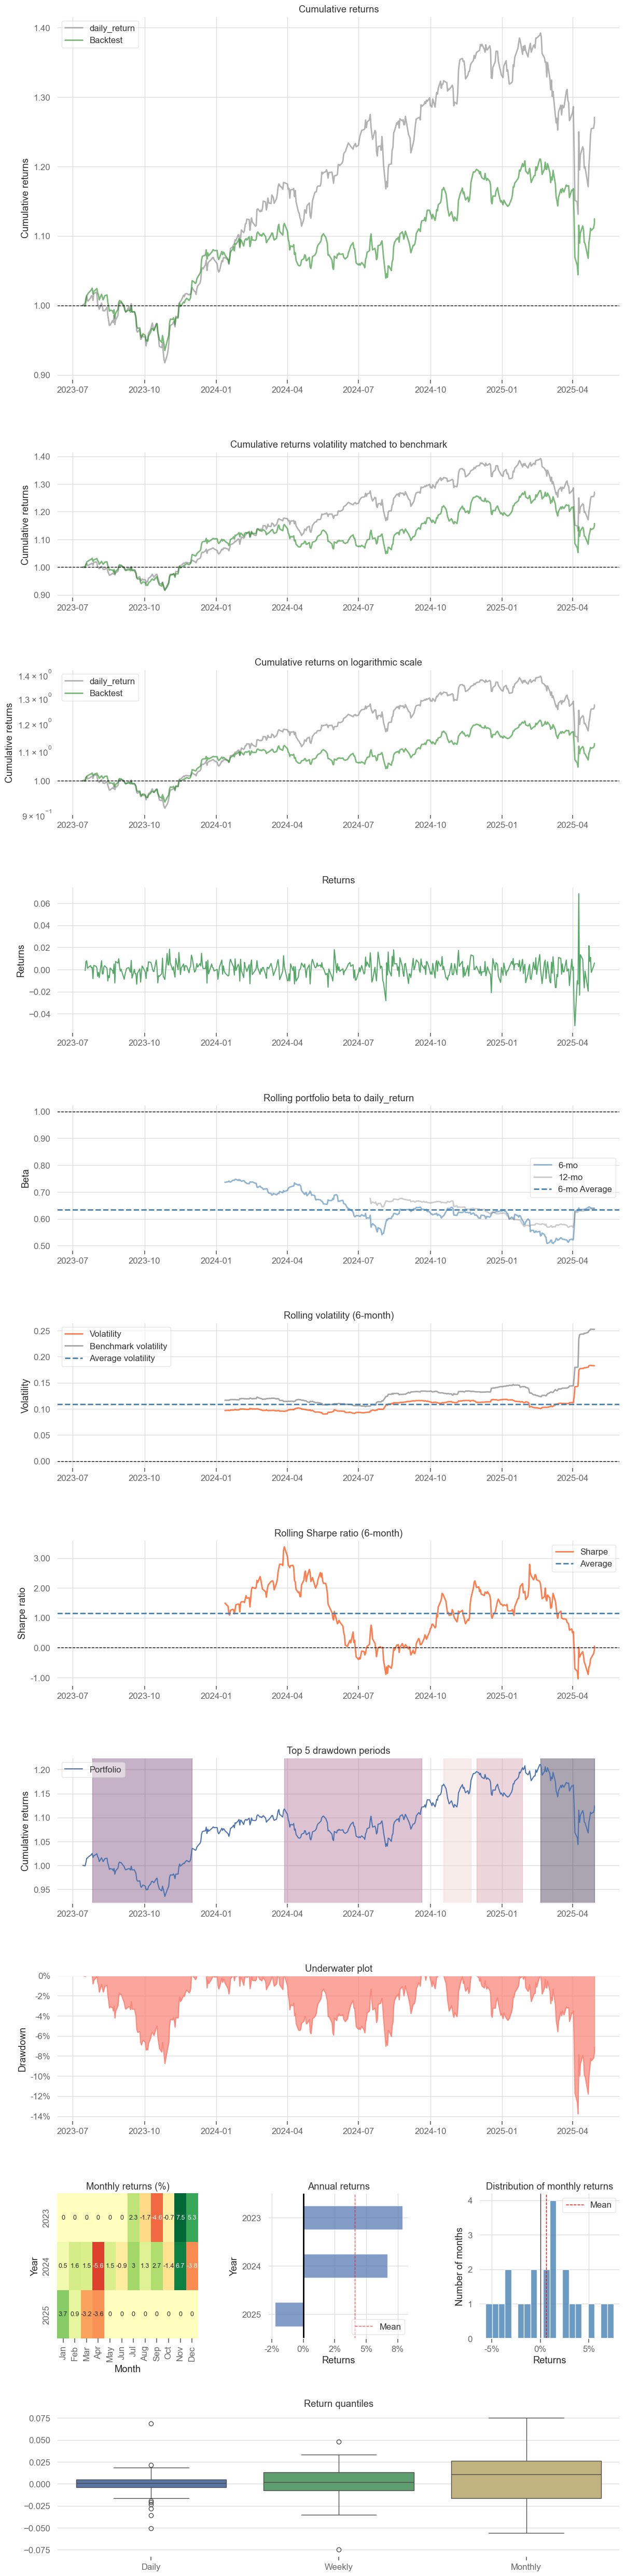

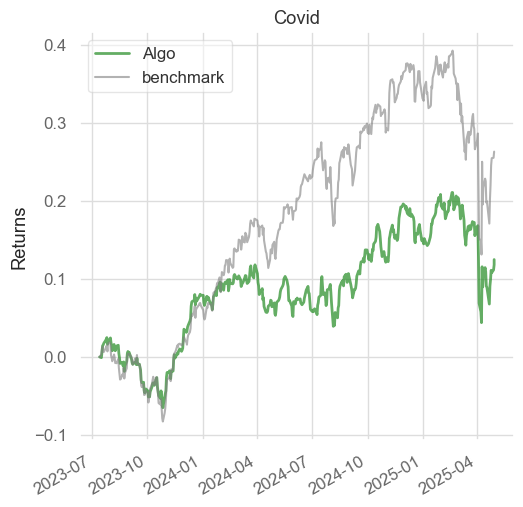

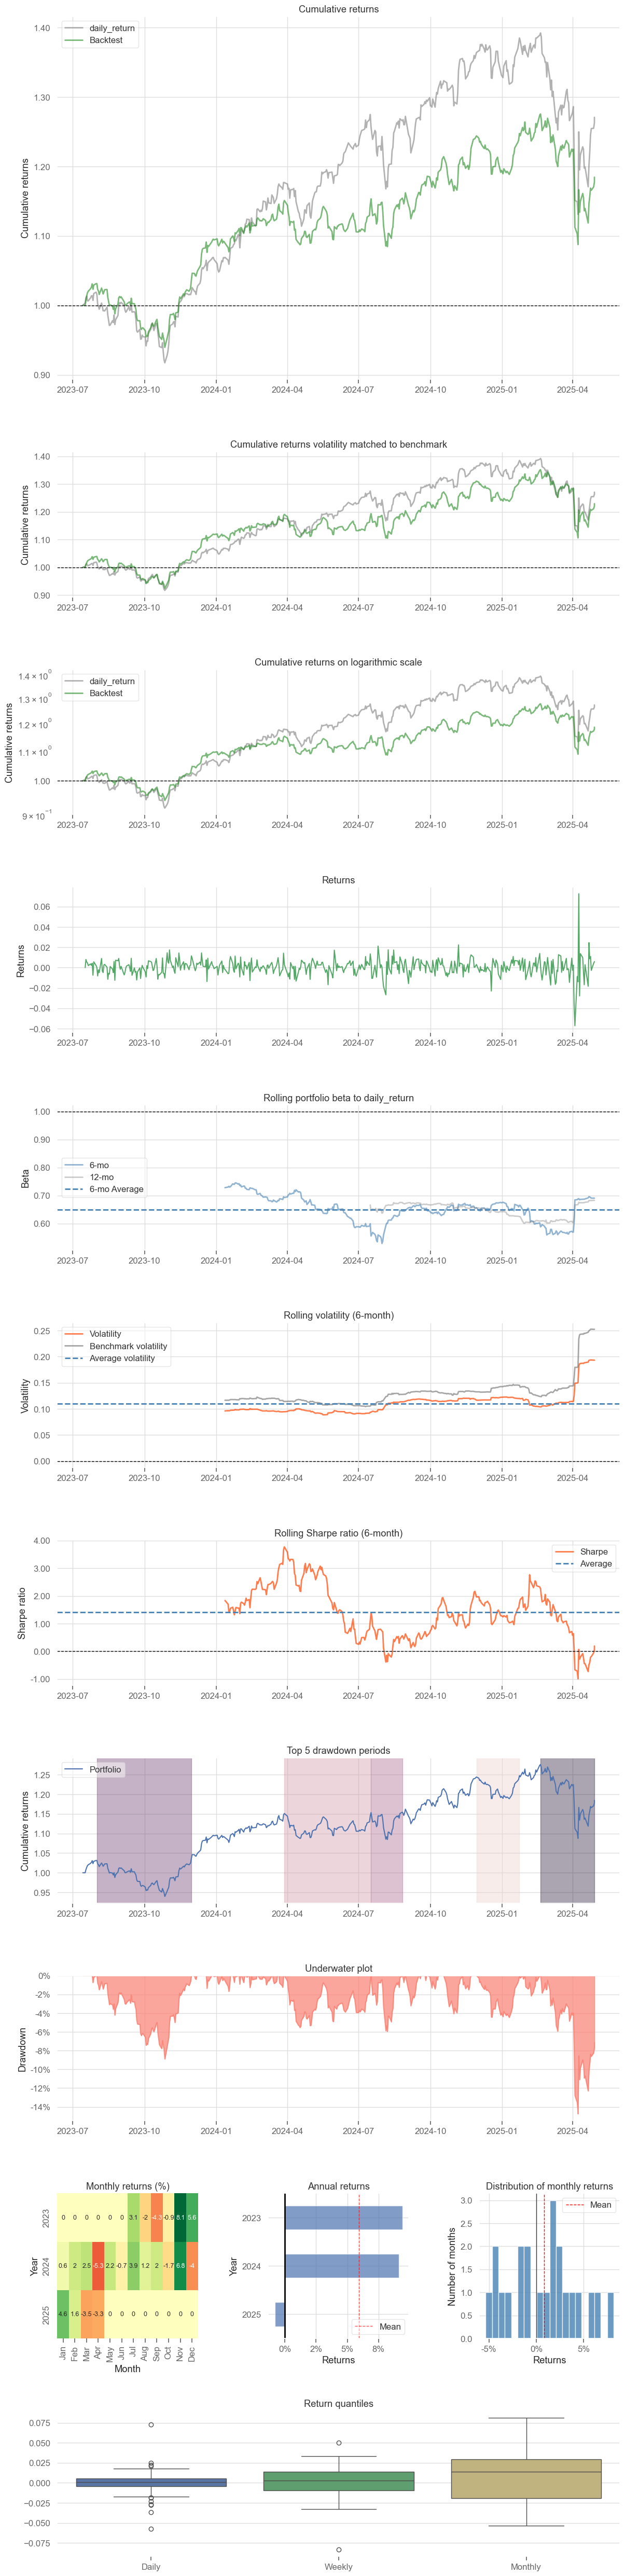

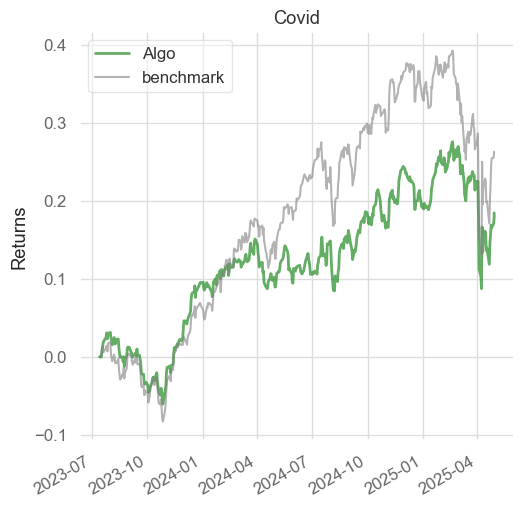

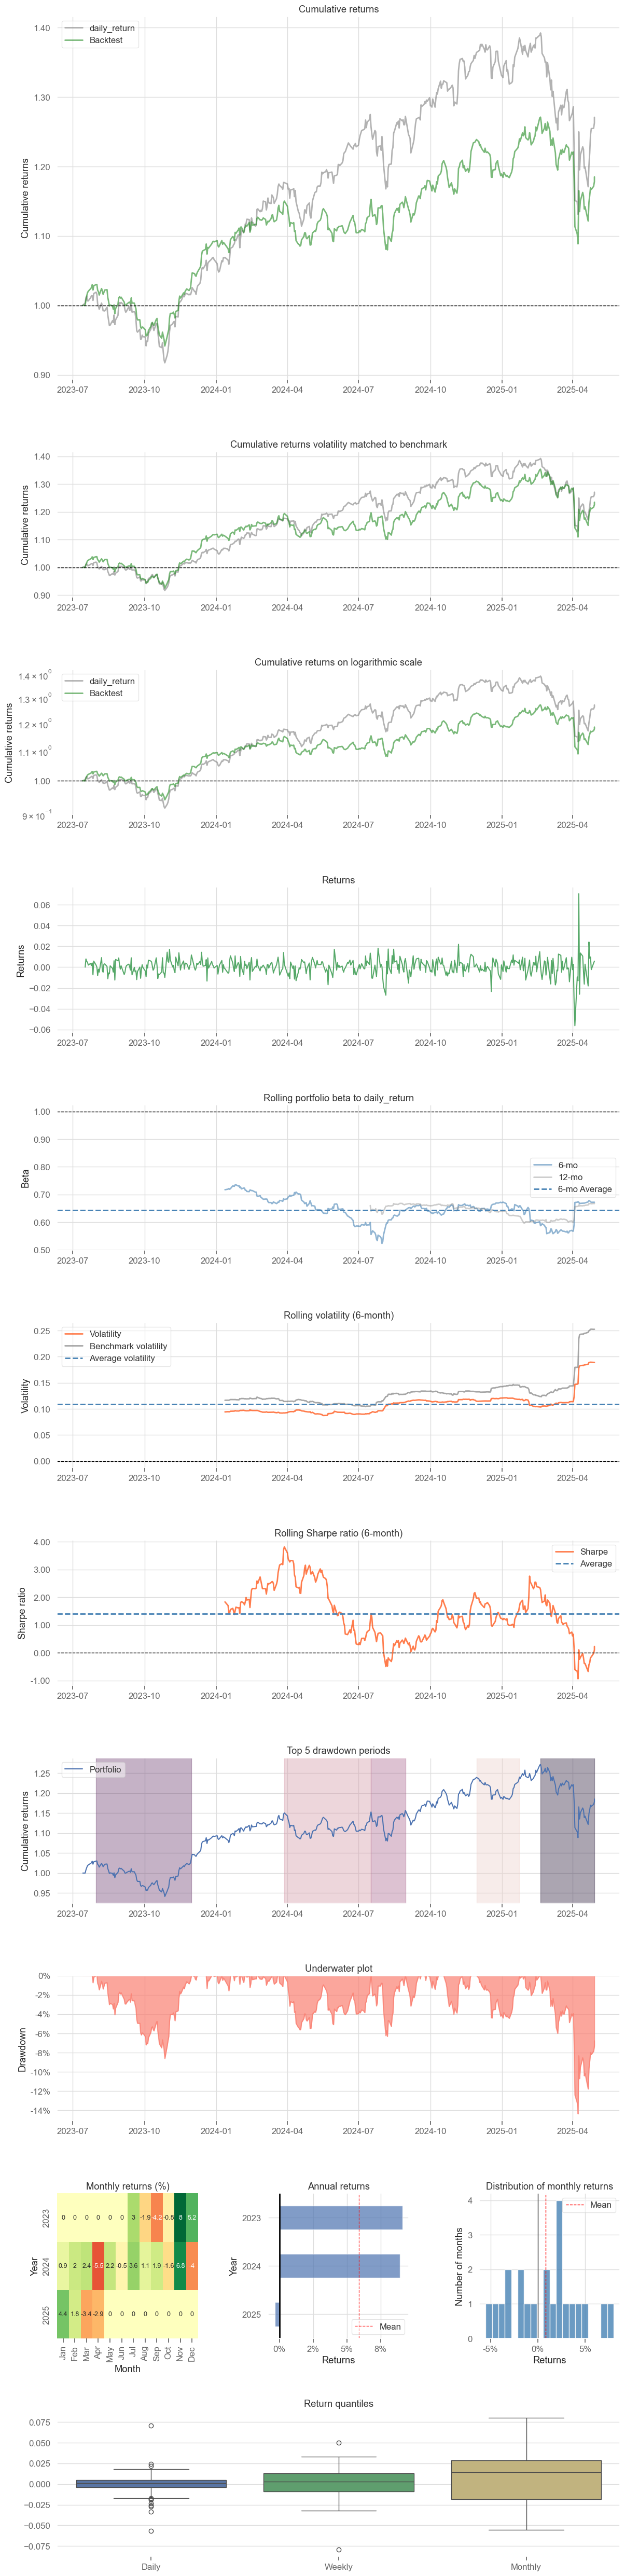

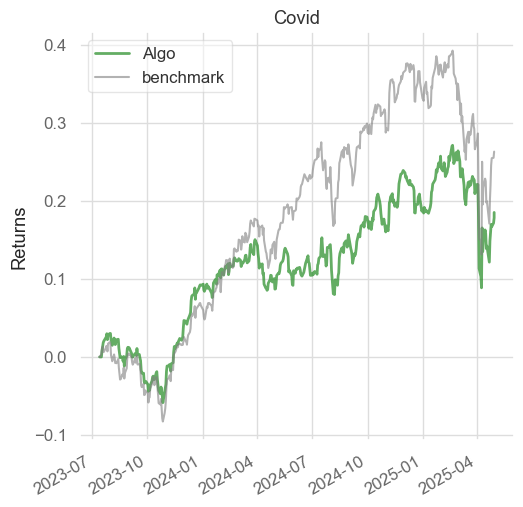

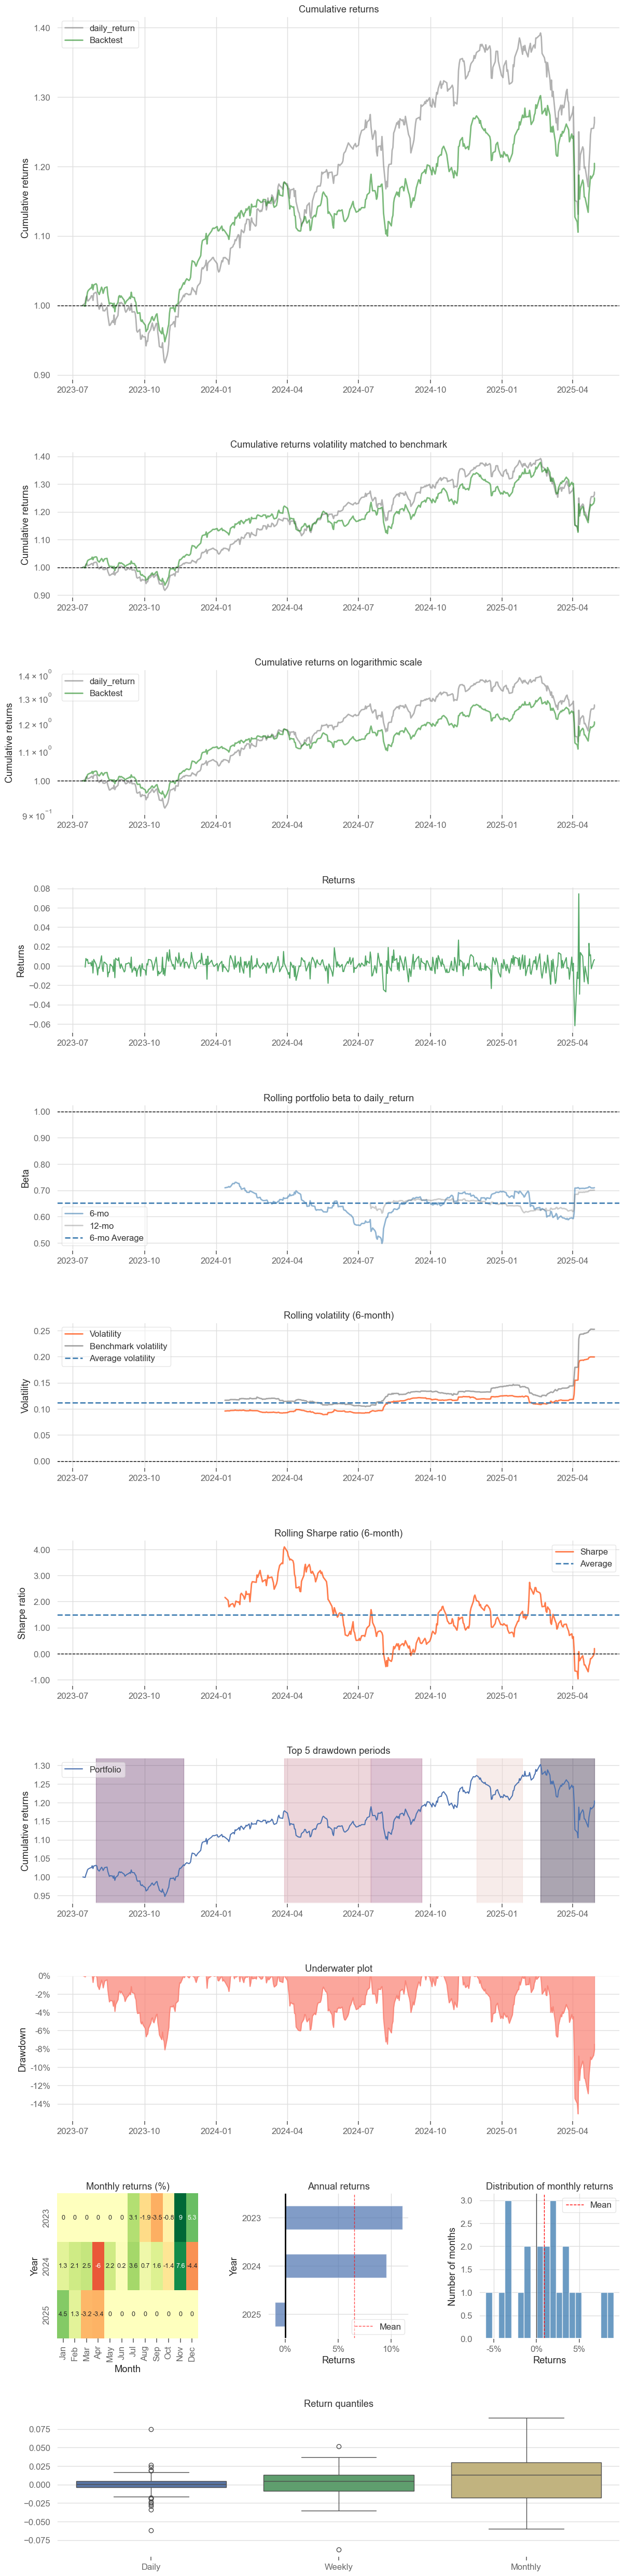

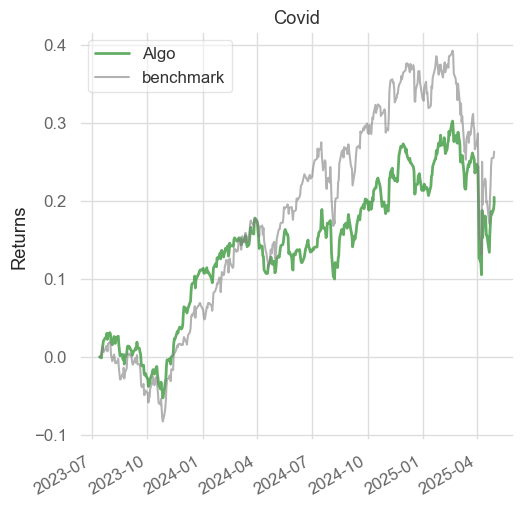

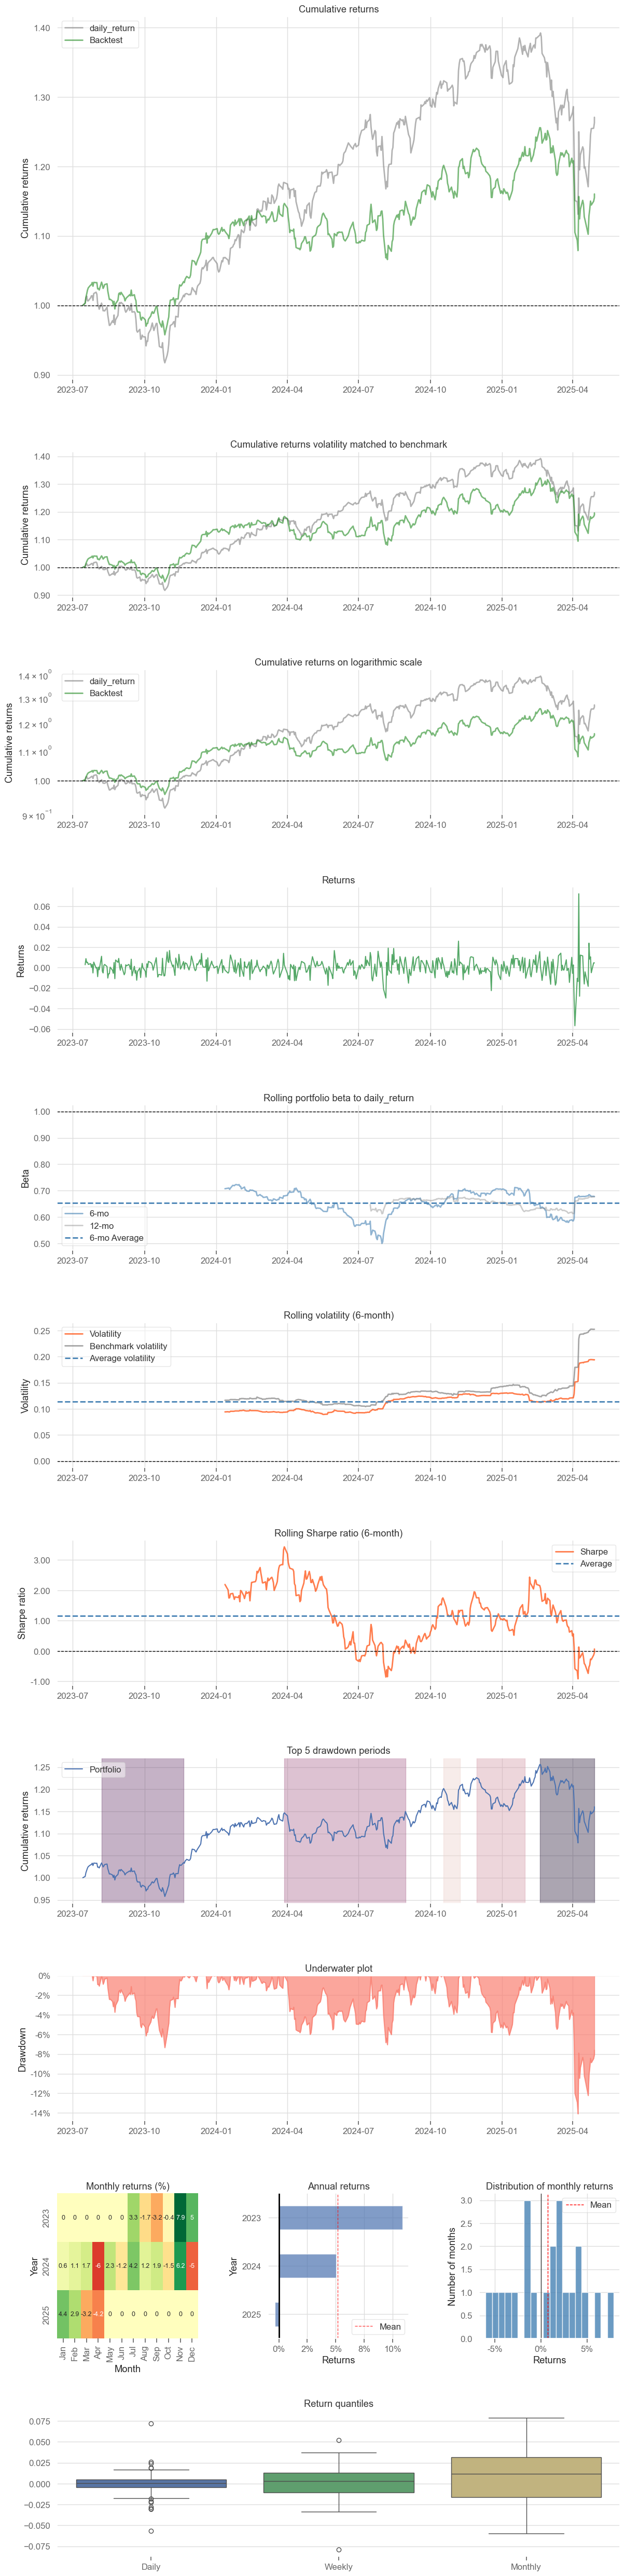

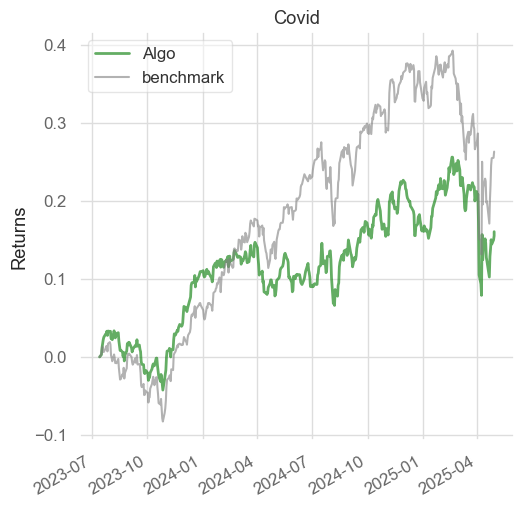

In [65]:
def plot_backtest_results():
    os.makedirs(f"{results_dir}/backtest_plots", exist_ok=True)
    for name, res in results.items():
        print(f"Plotting {name}…")
        backtest_plot(
            account_value=res["df"],
            baseline_start=test_start_date,
            baseline_end=end_date,
            baseline_ticker="SPY",
            value_col_name="account_value",
        )


plot_backtest_results()

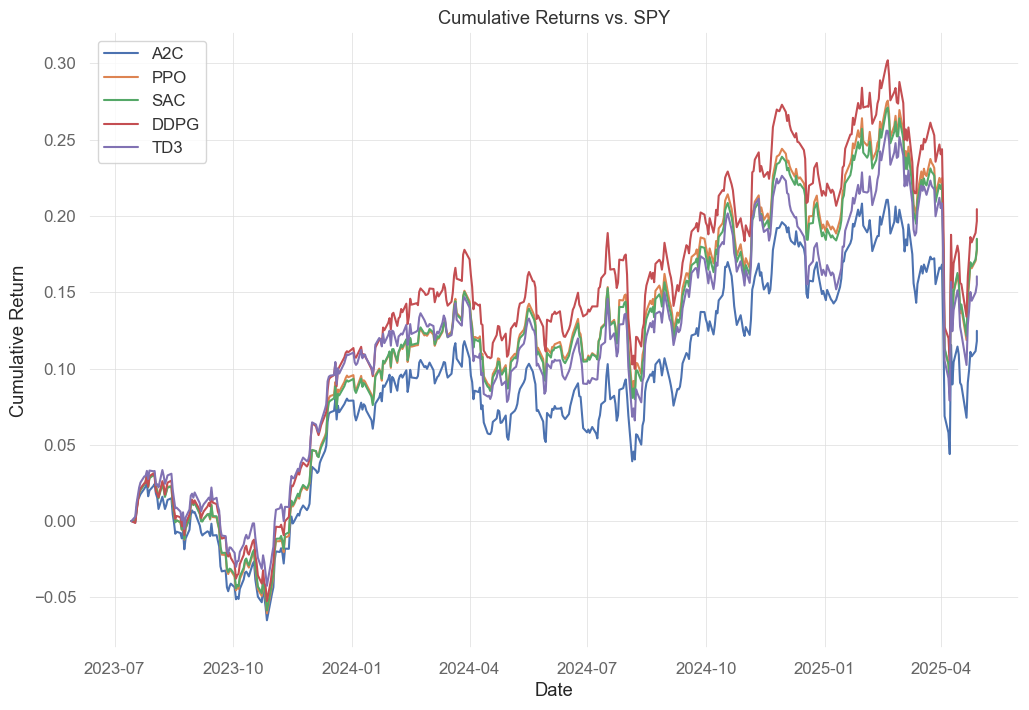

In [66]:
def plot_cumulative_returns(results):
    plt.figure(figsize=(12, 8))
    for name, res in results.items():
        df = res["df"]
        # compute cumulative returns from account_value
        cum = df["account_value"] / df["account_value"].iloc[0] - 1
        plt.plot(df["date"], cum, label=name)
    plt.title("Cumulative Returns vs. SPY")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.show()


plot_cumulative_returns(results)

## Benchmarks


In [67]:
def compute_mpt_benchmark(test, env_kwargs):
    dates_test = test.date.unique()
    min_vals = [env_kwargs["initial_amount"]]
    for i in range(len(dates_test) - 1):
        curr = test[test.date == dates_test[i]]
        nxt = test[test.date == dates_test[i + 1]]
        covm = np.array(curr.cov_list.values[0])
        ef = EfficientFrontier(None, covm, weight_bounds=(0, 1))
        ef.min_volatility()
        w = ef.clean_weights()
        prices = curr.close.values
        nextp = nxt.close.values
        shares = np.array(list(w.values())) * min_vals[-1] / prices
        min_vals.append(np.dot(shares, nextp))
    min_df = pd.DataFrame({"date": dates_test, "account_value": min_vals})
    stats_mpt = backtest_stats(min_df, value_col_name="account_value")
    return {"df": min_df, "stats": stats_mpt}


mpt_benchmark = compute_mpt_benchmark(test_df, env_kwargs)

Annual return          0.061565
Cumulative returns     0.125851
Annual volatility      0.110863
Sharpe ratio           0.595362
Calmar ratio           0.588030
Stability              0.847942
Max drawdown          -0.104696
Omega ratio            1.113979
Sortino ratio          0.857525
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.018633
Daily value at risk   -0.013705
dtype: float64


In [68]:
def compute_equal_weighted_benchmark(test, env_kwargs):
    ew_daily = test.groupby("date")["close"].apply(
        lambda d: d.pct_change().fillna(0).mean()
    )

    ew_df = ew_daily.reset_index(name="daily_return")
    ew_df["account_value"] = (ew_df.daily_return + 1).cumprod() * env_kwargs[
        "initial_amount"
    ]
    stats_ew = backtest_stats(ew_df, value_col_name="account_value")
    return {"df": ew_df, "stats": stats_ew}


ew_benchmark = compute_equal_weighted_benchmark(test_df, env_kwargs)

Annual return          1.414447e+50
Cumulative returns     3.199870e+99
Annual volatility      3.004435e+00
Sharpe ratio           4.979130e+01
Calmar ratio                    NaN
Stability              9.838324e-01
Max drawdown           0.000000e+00
Omega ratio                     NaN
Sortino ratio                   inf
Skew                            NaN
Kurtosis                        NaN
Tail ratio             2.151862e+00
Daily value at risk    2.151066e-01
dtype: float64


In [69]:
def compute_equal_weighted_benchmark(df, initial_amount=100_000):
    # Pivot to have one column per ticker
    price_wide = df.pivot_table(
        index="date", columns="tic", values="close"
    ).sort_index()

    # Compute each ticker's daily return, then average equally
    daily_rets = price_wide.pct_change().fillna(0).mean(axis=1)

    # Build the equity curve
    ew_df = pd.DataFrame({"date": daily_rets.index, "daily_return": daily_rets.values})
    ew_df["account_value"] = (ew_df["daily_return"] + 1).cumprod() * initial_amount

    # Compute performance statistics
    stats_ew = backtest_stats(ew_df, value_col_name="account_value")

    return {"df": ew_df.reset_index(drop=True), "stats": stats_ew}


ew_benchmark = compute_equal_weighted_benchmark(test_df, env_kwargs["initial_amount"])

Annual return          0.114421
Cumulative returns     0.239800
Annual volatility      0.135485
Sharpe ratio           0.868776
Calmar ratio           0.778318
Stability              0.867879
Max drawdown          -0.147010
Omega ratio            1.173176
Sortino ratio          1.283326
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.994491
Daily value at risk   -0.016602
dtype: float64


In [70]:
def compute_spy_benchmark(test, env_kwargs):
    spy_close = get_baseline("SPY", test.date.min(), test.date.max())["close"]
    spy_ret = spy_close.pct_change().dropna()
    spy_df = pd.DataFrame({"date": spy_ret.index, "daily_return": spy_ret.values})
    spy_df["account_value"] = (spy_df.daily_return + 1).cumprod() * env_kwargs[
        "initial_amount"
    ]
    stats_spy = backtest_stats(spy_df, value_col_name="account_value")
    return {"df": spy_df, "stats": stats_spy}


spy_benchmark = compute_spy_benchmark(test_df, env_kwargs)

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (499, 8)
Annual return          0.180049
Cumulative returns     0.387038
Annual volatility      0.163965
Sharpe ratio           1.093296
Calmar ratio           0.959995
Stability              0.873252
Max drawdown          -0.187552
Omega ratio            1.234540
Sortino ratio          1.626773
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.914000
Daily value at risk   -0.019946
dtype: float64


In [71]:
benchmarks = {
    "MPT": mpt_benchmark,
    "EW": ew_benchmark,
    "SPY": spy_benchmark,
}

results.update(benchmarks)

## Performance Summary


In [72]:
perf_stats = pd.DataFrame({key.upper(): res["stats"] for key, res in results.items()})
display(perf_stats)

A2C       PPO       SAC      DDPG       TD3  \
Annual return        0.067854  0.099239  0.099497  0.109531  0.086670   
Cumulative returns   0.124675  0.184519  0.185016  0.204440  0.160388   
Annual volatility    0.130003  0.134599  0.131948  0.137347  0.136110   
Sharpe ratio         0.570913  0.771693  0.786322  0.827043  0.679892   
Calmar ratio         0.492774  0.672959  0.692933  0.724859  0.614878   
Stability            0.717230  0.801139  0.802285  0.794829  0.749347   
Max drawdown        -0.137697 -0.147467 -0.143588 -0.151107 -0.140954   
Omega ratio          1.108245  1.152984  1.155546  1.167186  1.132019   
Sortino ratio        0.821645  1.115790  1.136042  1.189869  0.986647   
Skew                      NaN       NaN       NaN       NaN       NaN   
Kurtosis                  NaN       NaN       NaN       NaN       NaN   
Tail ratio           0.908752  0.944671  0.924479  0.958256  0.937660   
Daily value at risk -0.016084 -0.016546 -0.016212 -0.016853 -0.016781   

                          MPT        EW       SPY  
Annual return        0.061565  0.114421  0.180049  
Cumulative returns   0.125851  0.239800  0.387038  
Annual volatility    0.110863  0.135485  0.163965  
Sharpe ratio         0.595362  0.868776  1.093296  
Calmar ratio         0.588030  0.778318  0.959995  
Stability            0.847942  0.867879  0.873252  
Max drawdown        -0.104696 -0.147010 -0.187552  
Omega ratio          1.113979  1.173176  1.234540  
Sortino ratio        0.857525  1.283326  1.626773  
Skew                      NaN       NaN       NaN  
Kurtosis                  NaN       NaN       NaN  
Tail ratio           1.018633  0.994491  0.914000  
Daily value at risk -0.013705 -0.016602 -0.019946

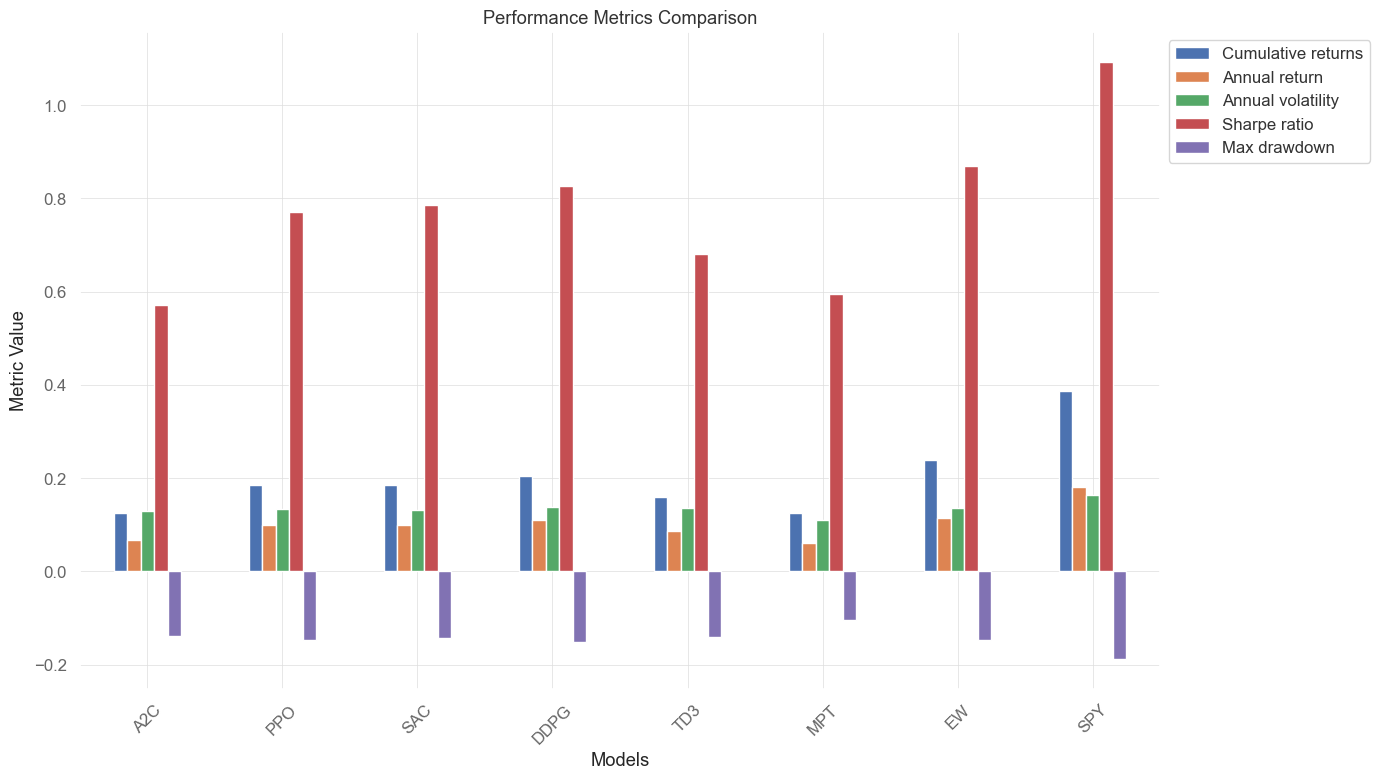

In [ ]:
metrics_to_include = [
    "Cumulative returns",
    "Annual return",
    "Annual volatility",
    "Sharpe ratio",
    "Max drawdown",
]
filtered_perf_stats = perf_stats.loc[metrics_to_include]

filtered_perf_stats.T.plot(kind='bar', figsize=(14, 8), legend=True)
plt.title("Performance Metrics Comparison")
plt.ylabel("Metric Value")
plt.xlabel("Models")
plt.xticks(rotation=45)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

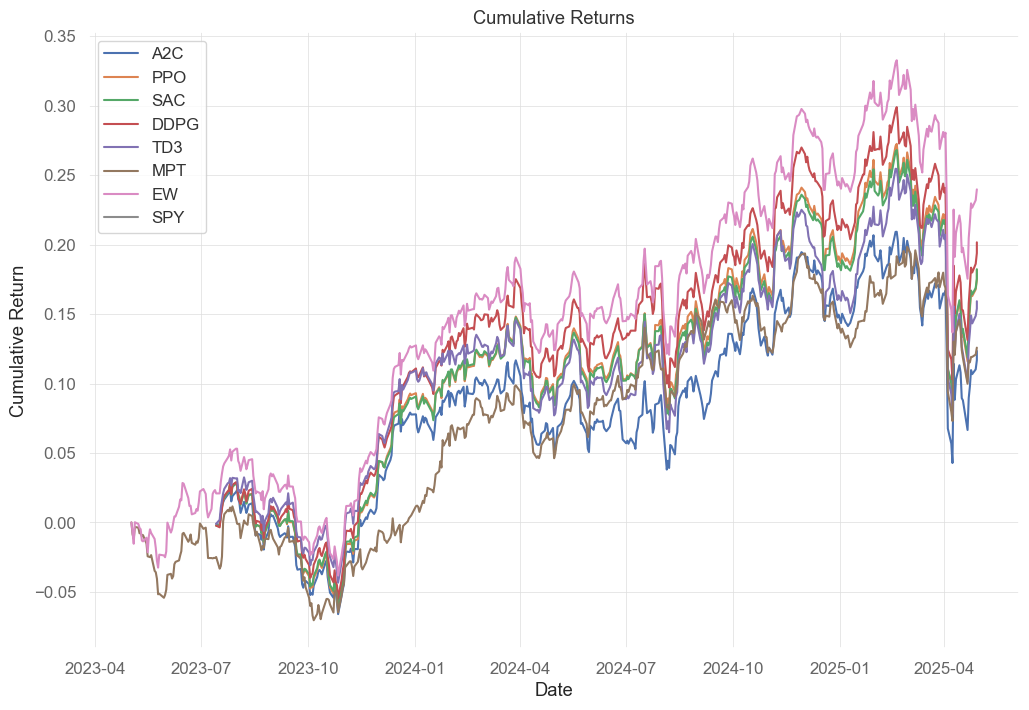

In [74]:
def plot_cumulative_returns(results):
    plt.figure(figsize=(12, 8))
    for name, res in results.items():
        # Ensure the date column is converted to datetime
        res["df"]["date"] = pd.to_datetime(res["df"]["date"])
        # Filter data to start from the trade start date
        filtered_df = res["df"][res["df"]["date"] >= test_start_date]
        cum = (
            (filtered_df["daily_return"] + 1).cumprod() - 1
            if "daily_return" in filtered_df
            else filtered_df["account_value"] / filtered_df["account_value"].iloc[0] - 1
        )
        plt.plot(filtered_df["date"], cum, label=name)
    plt.title("Cumulative Returns")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.show()


plot_cumulative_returns(results)